In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


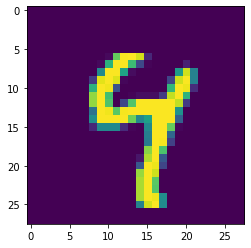

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
X_tr=np.reshape(mnist.train.images,[-1,28,28])
Y_tr=mnist.train.labels
X_te=np.reshape(mnist.test.images,[-1,28,28])
Y_te=mnist.test.labels
plt.imshow(X_tr[2,:,:])

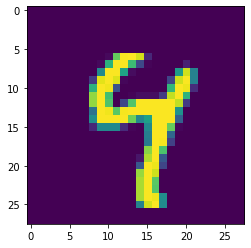

In [3]:
Permutation=False

if Permutation:

    X_tr=mnist.train.images
    Y_tr=mnist.train.labels
    X_te=mnist.test.images
    Y_te=mnist.test.labels

    P=np.shape(X_tr)[1]
    permutation=np.random.permutation(P)

    X_tr=X_tr[:,permutation]
    X_te=X_te[:,permutation]

    X_tr=np.reshape(X_tr,[-1,28,28])
    X_te=np.reshape(X_te,[-1,28,28])
    
plt.imshow(X_tr[2,:,:])

## ESN, definition of the graph for the computation of the activities

In [4]:
class Echo:
    
    def __init__(self,dt,tau_m,tau_M,diluition,N,W_in):
            
            self.dt=dt
            self.N=N
            self.tau_m=tau_m
            self.tau_M=tau_M
            self.Diluition=diluition
            
            W_np=np.random.uniform(-1,1,[N,N])
            D=np.random.uniform(0,1,(N,N))>np.ones((N,N))*diluition
            W_np=W_np*D.astype(int)
            
            eig=np.linalg.eigvals(W_np)
            self.eig=eig
            
            alpha_np=dt/(2*tau_m)
            pho_np=1-2*tau_m/tau_M
            
            W_np=pho_np*W_np/(np.max(np.absolute(eig)))
            
            self.W_np=W_np
            self.alpha_np=alpha_np
            self.pho_np=pho_np
            
            self.W=tf.Variable(W_np,trainable=False,dtype=tf.float32)
            self.alpha=tf.constant(alpha_np,dtype=tf.float32)
            
            self.W_in_np=W_in
            self.W_in=tf.Variable(W_in,trainable=False,dtype=tf.float32)
            self.N_in=np.shape(W_in)[0]
            
            
    def evolution_graph(self,T,init_state,inputs):

        
        state_hidden=init_state
        states_hidden=[]
        xs=[]
        
        
        for t in range(T):
            
            prev_state=tf.identity(state_hidden)
            state_hidden=( (1-self.alpha)*prev_state+self.alpha*tf.tanh( tf.matmul(prev_state,self.W)+tf.matmul(inputs[:,:,t],self.W_in) ))
            states_hidden.append(state_hidden)
            
        states=tf.concat([tf.expand_dims(s,2) for s in states_hidden],2)

    
        return states, state_hidden


## Computation of the NN response across the whole dataset

The next cell computes the states of the ESN across the whole dataset. 

Instructions for updating:
Colocations handled automatically by placer.
Computing States for the training set
Computing States for the test set


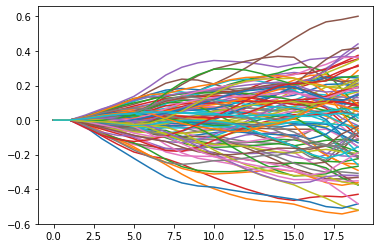

In [5]:
N=1000                                        
dt=0.01
tau_m=0.03
tau_M=2
diluition=0.99

N_train=np.shape(X_tr)[0]

T=np.shape(X_tr)[2]
N_class=np.shape(Y_tr)[1]
N_proj=np.shape(X_tr)[1]

W_in=np.random.randn(N,N_proj)
W_in=0.1*W_in.T

rnn=Echo(dt,tau_m,tau_M,diluition,N,W_in)

init_state=tf.placeholder(tf.float32,[None,N])
s=tf.placeholder(tf.float32,[None,N_proj,T])

states,state=rnn.evolution_graph(T,init_state,s)

init=tf.global_variables_initializer()

train_divide=20
N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

Data_train=np.zeros([np.shape(Y_tr)[0],N,T])

test_divide=10
N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))

Data_test=np.zeros([np.shape(Y_te)[0],N,T])


with tf.Session() as sess:
    
    sess.run(init)
    
    print('Computing States for the training set')
    
    for l in range(train_divide):
                
        images=X_tr[l*N_train_d:(l+1)*N_train_d,:,:]
        labels=Y_tr[l*N_train_d:(l+1)*N_train_d,:]

        states_=sess.run(states,feed_dict={init_state:np.zeros([N_train_d,N]),s:images})
        
        Data_train[l*N_train_d:(l+1)*N_train_d,:,:]=states_
    
    print('Computing States for the test set')
    
    for l in range(test_divide):
                
        images=X_te[l*N_test_d:(l+1)*N_test_d,:,:]
        labels=Y_te[l*N_test_d:(l+1)*N_test_d,:]

        states_=sess.run(states,feed_dict={init_state:np.zeros([N_test_d,N]),s:images})
        
        Data_test[l*N_test_d:(l+1)*N_test_d,:,:]=states_
            
            
show_example=True

if show_example:
    for i in range(100):
        plt.plot(Data_train[0,i,0:20])

## Tensorflow graph for the training

The following class handles the training of 2 possible models:

<ul>
    <li> SpaRCe: training of N_copies NNs starting from different initial conditions, i.e. different starting sparsity level.            The algorithm is composed by an initialisation phase (it initialises the starting value of the thresholds, theta_g)            and a training phase (where the thresholds theta_i and the output weights W_out are optimised). The thresholds are              theta=theta_g+theta_i, where the first factor corresponds to the initialisation, and the second factor is optimised            (this split is due to convenience, to have the possibility to check each factor separately)  </li>
    <li> ESN: Training of the readout of an ESN. It is possible to compute the performance as the learning rate varies by                selecting scan=True. </li>
 </ul>
 
The hyperparameters suggested are already in a good configuration. 
 
    
    

In [6]:
class Models:
    
    def __init__(self,N,N_class,alpha_size,batch_size,N_ep):
        
        self.T=28
        
        self.N=N
        
        self.N_class=N_class
        
        self.alpha_size=alpha_size
        
        self.batch_size=batch_size
        
        self.N_episodes=N_ep
        
        
    def ESN(self,state,y_true,scan,N_copies):
        
        if scan==False:
    
            alpha_sizes=[self.alpha_size]
                               
        
        if scan==True:
            
            alpha_sizes=0.002*2**(-np.linspace(0,4,5))
            
        W_out=[]
        y=[]
        error=[]
        train=[]

        for i in range(N_copies):

            W_out.append(tf.Variable(np.random.uniform(-1,1,[self.N*self.T,self.N_class])/(self.N/10),dtype=tf.float32))

            y.append( tf.matmul(state,W_out[i]) )

            error.append(tf.losses.sigmoid_cross_entropy(y_true,y[i]))

            train.append(tf.train.AdamOptimizer(learning_rate=alpha_sizes[i]).minimize(error[i],var_list=[W_out[i]]))


        return y, error, train 
    
    def SpaRCe(self,state,y_true,theta_g_start):
        
        theta_g=[]
        theta_i=[]
        W_out=[]
        state_sparse=[]
        y=[]
        error=[]
        train1=[]
        train2=[]
                
        theta_istart=np.random.randn(N,self.T)/N
        theta_istart=np.reshape(theta_istart,[-1,N*self.T])

        for i in range(N_copies):

            theta_g.append(tf.Variable(theta_g_start[i], trainable=False, dtype=tf.float32))

            theta_i.append(tf.Variable(theta_istart,dtype=tf.float32))

            W_out.append(tf.Variable(np.random.uniform(0,1,[self.N*self.T,N_class])/(N),dtype=tf.float32))
            
            state_sparse.append(tf.sign(state)*tf.nn.relu(tf.abs(state)-theta_g[i]-theta_i[i]))     

            y.append(tf.matmul(state_sparse[i],W_out[i]))

            error.append(tf.losses.sigmoid_cross_entropy(y_true,y[i]))
    
            train1.append(tf.train.AdamOptimizer(learning_rate=alpha_size).minimize(error[i],var_list=[W_out[i]]))
            train2.append(tf.train.AdamOptimizer(learning_rate=alpha_size/10).minimize(error[i],var_list=[theta_i[i]]))

            train=train1+train2
        
        
        return state_sparse, y, error, train
        
        

## TRAINING

It is possible to specify the model to train (SpaRCe or readout of ESN).

In [8]:
tf.reset_default_graph()

dt=0.01

diluition=0.99

N_episodes=300000
N_check=100


N_train=np.shape(X_tr)[0]

T=np.shape(X_tr)[2]
N_class=np.shape(Y_tr)[1]
N_proj=np.shape(X_tr)[1]

train_divide=10

N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

test_divide=5

N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))


MODEL=1

if MODEL==1:
    
    alpha_size=0.002                                                  # Learning rate
    batch_size=20    
    NN_model=Models(N,N_class,alpha_size,batch_size,N_episodes)
    
    theta_g_start=[]
    
    N_copies=5
    
    
    # INITIALISATION
    for n in range(N_copies):

        theta_g_start_help=np.zeros([N,T])

        for t in range(T):

            state_help=Data_train[:,:,t]

            theta_g_start_help[:,t]=np.percentile(np.abs(state_help),(100/N_copies)*n,0)
            
        theta_g_start.append(np.reshape(theta_g_start_help,[-1,T*N]))
    
    States_tr=np.reshape(Data_train,[-1,N*T])
    States_te=np.reshape(Data_test,[-1,N*T])
    
    s=tf.placeholder(tf.float32,[None,N*T])
    y_true=tf.placeholder(tf.float32,[None,N_class])

    state_sparse, y, error, train = NN_model.SpaRCe(s,y_true,theta_g_start)
    
if MODEL==2:
    
    alpha_size=0.0005                                               # Learning rate
    batch_size=20
    
    N_copies=5
    scan=False
    
    if scan==False:
        N_copies=1
    
    NN_model=Models(N,N_class,alpha_size,batch_size,N_episodes)
    
    States_tr=np.reshape(Data_train,[-1,N*T])
    States_te=np.reshape(Data_test,[-1,N*T])
    
    s=tf.placeholder(tf.float32,[None,N*T])
    y_true=tf.placeholder(tf.float32,[None,N_class])
    
    y, error, train = NN_model.ESN(s,y_true,scan,N_copies)
    

init=tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    for n in range(N_episodes):
    
        if n>0:

            rand_ind=np.random.randint(0,N_train,(batch_size,))

            images=States_tr[rand_ind,:]

            labels=Y_tr[rand_ind,:]

            _=sess.run([t for t in train],feed_dict={y_true:labels,s:images})


        if n%(np.round(N_episodes/N_check))==0:

            index_help=int(n/(np.round(N_episodes/N_check)))

            for i in range(N_copies):

                matches=tf.equal(tf.argmax(y_true,1),tf.argmax(y[i],1))
                p=tf.reduce_mean(tf.cast(matches,tf.float32))
                
                if MODEL==2:
                    
                    images=States_te[:,:]
                    labels=Y_te[:,:]

                    p_test,error_test=sess.run([p,error[i]],feed_dict={y_true:labels,s:images})
                    
                    print('Iteration: ',n,'ESN ',i,'Probability: ',p_test,'Error: ',error_test)
                    
                    p_train=0
                    error_train=0
                    
                    for l in range(train_divide):
                        
                        images=States_tr[l*N_train_d:(l+1)*N_train_d,:]
                        labels=Y_tr[l*N_train_d:(l+1)*N_train_d,:]
                    
                        p_train_,error_train_=sess.run([p,error[i]],feed_dict={y_true:labels,s:images})
                        
                        p_train=p_train+p_train_/train_divide
                        error_train=error_train+error_train_/train_divide
                        
                    print('Iteration: ',n,'ESN ',i,'Probability: ',p_train,'Error: ',error_train)
                    
                if MODEL==1:
                    
                    
                    images=States_te[:,:]
                    labels=Y_te[:,:]
                    
                    p_test=0
                    error_test=0
                    cl=0
                    
                    for l in range(test_divide):
                    
                        images=States_te[l*N_test_d:(l+1)*N_test_d,:]
                        labels=Y_te[l*N_test_d:(l+1)*N_test_d,:]
                    
                        state_,p_test_,error_test_=sess.run([state_sparse[i],p,error[i]],feed_dict={y_true:labels,s:images})
                        cl_=np.sum(state_!=0)/np.sum(N*np.sum(np.sum(X_te!=0,1)!=0,1))
                        
                        p_test=p_test+p_test_/test_divide
                        error_test=error_test+error_test_/test_divide
                        cl=cl+cl_
                        
                    print('Iteration: ',n,'SpaRCe ',i,'Probability: ',p_test,'Error: ',error_test,'Coding ',cl)
                    
                    p_train=0
                    error_train=0
                    cl=0
                    
                    for l in range(train_divide):
                    
                        images=States_tr[l*N_train_d:(l+1)*N_train_d,:]
                        labels=Y_tr[l*N_train_d:(l+1)*N_train_d,:]
                    
                        state_,p_train_,error_train_=sess.run([state_sparse[i],p,error[i]],feed_dict={y_true:labels,s:images})
                        cl_=np.sum(state_!=0)/np.sum(N*np.sum(np.sum(X_tr!=0,1)!=0,1))
                        
                        p_train=p_train+p_train_/train_divide
                        error_train=error_train+error_train_/train_divide
                        cl=cl+cl_
                        
                    print('Iteration: ',n,'SpaRCe ',i,'Probability: ',p_train,'Error: ',error_train,'Coding ',cl)
                



Iteration:  0 SpaRCe  0 Probability:  0.11959999948740004 Error:  0.6909878730773925 Coding  1.365734047753821
Iteration:  0 SpaRCe  0 Probability:  0.11416363492608071 Error:  0.6910945355892181 Coding  1.3604146942428275
Iteration:  0 SpaRCe  1 Probability:  0.14389999806880951 Error:  0.6920907974243165 Coding  1.1396472495240055
Iteration:  0 SpaRCe  1 Probability:  0.14958181828260422 Error:  0.6922027707099915 Coding  1.1306534910884989
Iteration:  0 SpaRCe  2 Probability:  0.07769999951124192 Error:  0.6925931334495543 Coding  0.8791264151186127
Iteration:  0 SpaRCe  2 Probability:  0.07583636417984962 Error:  0.6926899611949922 Coding  0.8696962314258984
Iteration:  0 SpaRCe  3 Probability:  0.11019999980926513 Error:  0.6927983403205872 Coding  0.6016473846035095
Iteration:  0 SpaRCe  3 Probability:  0.10389090925455093 Error:  0.6928744614124297 Coding  0.5947811635218299
Iteration:  0 SpaRCe  4 Probability:  0.15569999814033508 Error:  0.6931610107421875 Coding  0.3092861241

KeyboardInterrupt: 

In [ ]:
np.savetxt('PMnist_Accuracy.txt',p_ra_save)
np.savetxt('PMnist_cl.txt',cl_save)